In [1]:
import os
os.chdir("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")

In [2]:
import pysam
import pandas as pd
import numpy as np
import multiprocessing as mp
from functools import partial
import time
import swalign

def reverse_complement(seq):
    """生成反向互补序列"""
    comp = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
    return ''.join(comp.get(base, 'N') for base in reversed(seq))

# 预初始化全局比对器，避免重复创建的开销
_match_score = 2
_mismatch_score = -2
_gap_penalty = -3
_gap_extension_penalty = -1
_scoring = swalign.NucleotideScoringMatrix(_match_score, _mismatch_score)
_aligner = swalign.LocalAlignment(_scoring, _gap_penalty, _gap_extension_penalty)

def find_tso_positions(sequence, tso_seq, tso_rc, min_score_ratio=0.6):
    """
    使用swalign库进行局部比对查找TSO位置
    允许较高的错误率，基于Smith-Waterman算法
    """
    positions = []
    tso_length = len(tso_seq)
    
    # 计算完美匹配得分（用于相似度计算）
    perfect_score = tso_length * _match_score
    score_threshold = perfect_score * min_score_ratio
    
    # 检查正向TSO序列
    try:
        result_forward = _aligner.align(tso_seq, sequence)
        if result_forward.score >= score_threshold:
            similarity = result_forward.score / perfect_score
            positions.append(('forward', result_forward.q_pos, {
                'score': result_forward.score,
                'similarity': similarity,
                'matches': result_forward.matches,
                'cigar': str(result_forward.cigar),
                'method': 'swalign'
            }))
    except Exception as e:
        # 静默处理错误，避免输出过多日志影响性能
        pass
    
    # 检查反向互补TSO序列
    try:
        result_rc = _aligner.align(tso_rc, sequence)
        if result_rc.score >= score_threshold:
            similarity = result_rc.score / perfect_score
            positions.append(('reverse_complement', result_rc.q_pos, {
                'score': result_rc.score,
                'similarity': similarity,
                'matches': result_rc.matches,
                'cigar': str(result_rc.cigar),
                'method': 'swalign'
            }))
    except Exception as e:
        # 静默处理错误
        pass
    
    return positions
    
def process_single_read_data(read_data, tso_sequence, tso_rc, min_similarity=0.6):
    """
    处理单个read的数据，为每个TSO比对位置创建单独记录
    修正：在完整read序列上比对，直接获取TSO在read上的绝对位置。
    """
    # 从字典中获取数据
    read_id = read_data['read_id']
    read_sequence = read_data['sequence']  # 完整的read序列
    read_length = read_data['length']
    has_supplementary = read_data['has_supplementary']
    tso_length = len(tso_sequence)

    if not read_sequence or read_length < tso_length:
        return []

    # 【关键修正】直接在完整的read序列上使用局部比对方法查找TSO
    tso_positions = find_tso_positions(read_sequence, tso_sequence, tso_rc, 
                                      min_score_ratio=min_similarity)
    
    # 为每个TSO比对位置创建单独记录
    results = []
    for direction, position, alignment_info in tso_positions:
        # 此时 position 已经是相对于完整read序列的起始位置（0-based）
        # 如果您希望位置从1开始计数（1-based），可以： position + 1
        absolute_position = position  # 0-based
        # absolute_position = position + 1  # 1-based

        result = {
            'read_id': read_id,
            'read_length': read_length,
            'has_supplementary': has_supplementary,
            'direction': direction,
            'position': absolute_position,  # 使用修正后的绝对位置
            'score': alignment_info['score'],
            'similarity': alignment_info['similarity'],
            'matches': alignment_info.get('matches', 'N/A'),
            'cigar': alignment_info.get('cigar', 'N/A'),
            'method': alignment_info.get('method', 'swalign')
        }
        results.append(result)
    
    # 如果没有找到任何TSO匹配，创建一条记录表明未找到
    if not tso_positions:
        results.append({
            'read_id': read_id,
            'read_length': read_length,
            'supplementary': has_supplementary,
            'direction': 'not_found',
            'position': -1,  # 用-1或其他标志值表示未找到
            'score': 0,
            'similarity': 0,
            'matches': 0,
            'cigar': 'N/A',
            'method': 'N/A'
        })
    
    return results


def process_read_data_chunk(read_data_chunk, tso_sequence, tso_rc, min_similarity=0.6):
    """
    处理一个read数据块（接收的是已提取的字典数据，而非pysam对象）
    """
    chunk_results = []
    for read_data in read_data_chunk:
        results = process_single_read_data(read_data, tso_sequence, tso_rc, min_similarity)
        chunk_results.extend(results)
    return chunk_results

def analyze_bam_tso(bam_file_path, tso_sequence, output_csv="tso_analysis_results.csv", 
                   min_similarity=0.6, num_processes=None):
    """
    分析BAM文件中的TSO序列分布（使用多进程并行处理）
    
    参数:
        bam_file_path: BAM文件路径
        tso_sequence: TSO序列
        output_csv: 输出CSV文件名
        min_similarity: 最低相似度阈值
        num_processes: 进程数，默认为CPU核心数-1
    """
    # 生成反向互补TSO序列
    tso_rc = reverse_complement(tso_sequence)
    
    # 自动检测可用的CPU核心数
    if num_processes is None:
        num_processes = max(1, mp.cpu_count() - 1)  # 保留一个核心给系统

    print(f"开始处理BAM文件（使用{num_processes}个进程）...")
    print(f"TSO序列: {tso_sequence}")
    print(f"最低相似度阈值: {min_similarity}")
    print("模式: 记录所有TSO比对位置（一个read可能对应多条记录）")
    
    # 1. 在主进程中，预先读取BAM文件并将每个read转换为可序列化的字典
    bamfile = pysam.AlignmentFile(bam_file_path, "rb")
    all_reads_data = []  # 存储可序列化的read数据
    read_count = 0

    print("正在读取BAM文件并提取序列信息...")
    start_read_time = time.time()
    
    for read in bamfile:
        if read.is_unmapped or not read.query_sequence:
            continue
        is_chimeric = False
        if read.has_tag('SA'):
            is_chimeric = True
        # 提取关键信息，构成可pickle的字典
        read_data = {
            'read_id': read.query_name,
            'sequence': read.query_sequence,
            'length': read.query_length,
            'has_supplementary': is_chimeric
        }
        all_reads_data.append(read_data)
        read_count += 1
        
        if read_count % 100000 == 0:
            print(f"已提取 {read_count} 个reads的数据...")
    
    bamfile.close()
    end_read_time = time.time()
    print(f"数据提取完成，共 {len(all_reads_data)} 个reads，耗时 {end_read_time - start_read_time:.2f} 秒")

    if not all_reads_data:
        print("没有找到有效的reads数据。")
        return pd.DataFrame()

    # 2. 将可序列化的数据分块
    chunk_size = max(1, len(all_reads_data) // (num_processes * 4))
    data_chunks = [all_reads_data[i:i + chunk_size] for i in range(0, len(all_reads_data), chunk_size)]
    print(f"已将数据分成 {len(data_chunks)} 个块进行并行处理。")

    # 3. 准备多进程参数
    # 使用partial固定部分参数
    worker_func = partial(process_read_data_chunk, 
                         tso_sequence=tso_sequence, 
                         tso_rc=tso_rc, 
                         min_similarity=min_similarity)
    
    # 4. 使用多进程池
    results = []
    start_process_time = time.time()
    
    with mp.Pool(processes=num_processes) as pool:
        # 使用imap_unordered提高性能
        for i, chunk_results in enumerate(pool.imap_unordered(worker_func, data_chunks)):
            results.extend(chunk_results)
            if i % 10 == 0:  # 每处理10个块输出一次进度
                print(f"已处理 {i+1}/{len(data_chunks)} 个数据块，已生成 {len(results)} 条比对记录...")
    
    end_process_time = time.time()
    print(f"处理完成，耗时 {end_process_time - start_process_time:.2f} 秒")

    # 5. 保存结果
    if results:
        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        print(f"结果已保存至: {output_csv}")
        
        # 统计信息
        total_records = len(df)
        unique_reads = df['read_id'].nunique()
        reads_with_tso = df[df['direction'] != 'not_found']['read_id'].nunique()
        total_matches = len(df[df['direction'] != 'not_found'])
        
        print(f"生成总记录数: {total_records:,}")
        print(f"唯一reads数量: {unique_reads:,}")
        print(f"包含TSO匹配的reads数量: {reads_with_tso:,}")
        print(f"总TSO匹配次数: {total_matches:,}")
        print(f"平均每个read的TSO匹配数: {total_matches/unique_reads:.2f}")
        
        return df
    else:
        print("未产生任何有效结果。")
        return pd.DataFrame()

def calculate_statistics(df):
    """计算统计指标"""
    if df.empty:
        print("没有找到有效的记录")
        return
    
    total_records = len(df)
    unique_reads = df['read_id'].nunique()
    reads_with_tso = df[df['direction'] != 'not_found']['read_id'].nunique()
    total_matches = len(df[df['direction'] != 'not_found'])
    
    # 按方向统计
    forward_matches = len(df[df['direction'] == 'forward'])
    reverse_matches = len(df[df['direction'] == 'reverse_complement'])
    
    # 打印统计结果
    print("\n" + "="*60)
    print("TSO序列分析统计结果")
    print("="*60)
    print(f"总记录数: {total_records:,}")
    print(f"唯一reads数量: {unique_reads:,}")
    print(f"包含TSO匹配的reads数量: {reads_with_tso:,} ({reads_with_tso/unique_reads:.2%})")
    print(f"总TSO匹配次数: {total_matches:,}")
    print(f"正向TSO匹配: {forward_matches:,}")
    print(f"反向互补TSO匹配: {reverse_matches:,}")
    print(f"平均每个read的TSO匹配数: {total_matches/unique_reads:.2f}")
    
    # 如果有匹配，显示匹配得分的统计信息
    if total_matches > 0:
        match_df = df[df['direction'] != 'not_found']
        print(f"TSO匹配得分范围: {match_df['score'].min():.0f} - {match_df['tso_score'].max():.0f}")
        print(f"TSO匹配平均得分: {match_df['score'].mean():.2f}")
        print(f"TSO匹配相似度范围: {match_df['similarity'].min():.2%} - {match_df['tso_similarity'].max():.2%}")
        print(f"TSO匹配平均相似度: {match_df['similarity'].mean():.2%}")
    
    # Supplementary比对统计
    supplementary_total = df['has_supplementary'].mean()
    supplementary_with_tso = df[df['tso_direction'] != 'not_found']['has_supplementary'].mean()
    supplementary_no_tso = df[df['tso_direction'] == 'not_found']['has_supplementary'].mean()
    
    print(f"总体supplementary比对比例: {supplementary_total:.2%}")
    print(f"有TSO匹配的reads的supplementary比对比例: {supplementary_with_tso:.2%}")
    print(f"无TSO匹配的reads的supplementary比对比例: {supplementary_no_tso:.2%}")
    
    return {
        'total_records': total_records,
        'unique_reads': unique_reads,
        'reads_with_tso': reads_with_tso,
        'total_matches': total_matches,
        'forward_matches': forward_matches,
        'reverse_matches': reverse_matches,
        'supplementary_total': supplementary_total,
        'supplementary_with_tso': supplementary_with_tso,
        'supplementary_no_tso': supplementary_no_tso
    }


In [8]:
import pandas as pd
import numpy as np

def analyze_sequence_structures(df):
    """
    分析reads中的序列结构分布（修正版：过滤position为-1的无效匹配）
    
    参数:
        df: DataFrame，包含以下列:
            - position: TSO/CIDoligo在read上的位置（-1表示无匹配）
            - direction: 序列方向（forward/reverse_complement）
            - read_length: read的长度
            - has_supplementary: 是否存在supplementary比对
            - group: 序列类型（TSO/CIDoligo）
    
    返回:
        DataFrame: 包含每个read的结构分析结果
    """
    # 按read_id分组处理每个read的匹配信息
    results = []
    
    for read_id, group in df.groupby('read_id'):
        # 提取该read的基本信息
        read_length = group['read_length'].iloc[0]
        has_supplementary = group['has_supplementary'].iloc[0]
        
        # 分离TSO和CIDoligo的匹配，并过滤掉position为-1的无效匹配
        tso_matches = group[(group['group'] == 'TSO') & (group['position'] != -1)]
        cid_matches = group[(group['group'] == 'CIDoligo') & (group['position'] != -1)]
        cidp_matches = group[(group['group'] == 'CIDcap') & (group['position'] != -1)]
        
        # 检查结构A: TSO(正链) → cDNA → CIDoligo → TSO(负链)
        structure_A = check_structure_A(tso_matches, cid_matches, cidp_matches)
        
        # 检查结构B: TSO(负链) → cDNA → CIDoligo(负链) → TSO(正链)
        structure_B = check_structure_B(tso_matches, cid_matches, cidp_matches)
        
        # 检查结构C: TSO(正链) → cDNA → TSO(负链) (无CIDoligo)
        structure_C = check_structure_C(tso_matches, cid_matches, cidp_matches)

        structure_D = check_structure_D(tso_matches, cid_matches, cidp_matches)
        results.append({
            'read_id': read_id,
            'read_length': read_length,
            'has_supplementary': has_supplementary,
            'structure_A': structure_A,
            'structure_B': structure_B,
            'structure_C': structure_C,
            'structure_D': structure_D
        })
    
    return pd.DataFrame(results)

def check_structure_A(tso_matches, cid_matches, cidp_matches):
    """
    检查结构A: TSO(正链) → cDNA → CIDoligo → TSO(负链)
    """
    # 获取正向和反向TSO（已过滤position=-1的无效匹配）
    # tso_forward = tso_matches[tso_matches['direction'] == 'forward']
    # tso_reverse = tso_matches[tso_matches['direction'] == 'reverse_complement']
    
    # # 必须有正向TSO、反向TSO和至少一个CIDoligo匹配
    # if len(tso_forward) == 0 or len(tso_reverse) == 0 or len(cid_matches) == 0:
    #     return False
        
    if len(cid_matches) > 0 or len(cidp_matches) > 0:
        return True
    # 检查是否存在正向TSO < CIDoligo < 反向TSO的位置关系
    # for _, tf in tso_forward.iterrows():
    #     for _, tr in tso_reverse.iterrows():
    #         for _, cid in cid_matches.iterrows():
    #             if tf['position'] < cid['position'] < tr['position']:
    #                 return True
    #             if tr['position'] < cid['position'] < tf['position']:
    #                 return True
    return False

def check_structure_B(tso_matches, cid_matches, cidp_matches):
    if len(tso_matches) > 0 or len(cid_matches) > 0 or len(cidp_matches) > 0:
        return False
    return True

def check_structure_C(tso_matches, cid_matches, cidp_matches):
    """
    检查结构C: TSO(正链) → cDNA → TSO(负链) (无CIDoligo)
    """
    # 必须有TSO匹配且没有CIDoligo匹配（已过滤position=-1的无效匹配）
    if len(tso_matches) == 0 or len(cid_matches) > 0 or len(cidp_matches) > 0:
        return False
    
    # 获取正向和反向TSO
    tso_forward = tso_matches[tso_matches['direction'] == 'forward']
    tso_reverse = tso_matches[tso_matches['direction'] == 'reverse_complement']
    
    if len(tso_forward) != 0 and len(tso_reverse) != 0:
        return True
    return False

def check_structure_D(tso_matches, cid_matches, cidp_matches):
    """
    检查结构C: TSO(正链) → cDNA → TSO(负链) (无CIDoligo)
    """
    tso_forward = tso_matches[tso_matches['direction'] == 'forward']
    tso_reverse = tso_matches[tso_matches['direction'] == 'reverse_complement']
    # 必须有TSO匹配且没有CIDoligo匹配（已过滤position=-1的无效匹配）
    if len(tso_matches) == 0 or len(cid_matches) > 0 or len(cidp_matches) > 0:
        return False
    if len(tso_forward) != 0 and len(tso_reverse) != 0:
        return False
    return True

    
def calculate_structure_statistics(result_df):
    """
    计算序列结构的统计指标
    
    参数:
        result_df: analyze_sequence_structures函数返回的结果DataFrame
    
    返回:
        dict: 包含统计结果的字典
    """
    total_reads = len(result_df)
    
    if total_reads == 0:
        print("没有找到有效的reads")
        return {}
    
    # 各结构的reads数量
    count_A = result_df['structure_A'].sum()
    count_B = result_df['structure_B'].sum()
    count_C = result_df['structure_C'].sum()
    count_D = result_df['structure_D'].sum()
    # 各结构的比例
    prop_A = count_A / total_reads
    prop_B = count_B / total_reads
    prop_C = count_C / total_reads
    prop_D = count_D / total_reads
    
    # 各结构的supplementary比对比例
    supp_A = result_df[result_df['structure_A']]['has_supplementary'].mean() if count_A > 0 else 0
    supp_B = result_df[result_df['structure_B']]['has_supplementary'].mean() if count_B > 0 else 0
    supp_C = result_df[result_df['structure_C']]['has_supplementary'].mean() if count_C > 0 else 0
    supp_D = result_df[result_df['structure_D']]['has_supplementary'].mean() if count_C > 0 else 0
    # 总体supplementary比对比例
    supp_total = result_df['has_supplementary'].mean()
    
    # 返回统计结果
    stats = {
        'total_reads': total_reads,
        'CIDoligo/Cap': {'count': count_A, 'proportion': prop_A, 'supplementary_rate': supp_A},
        'None': {'count': count_B, 'proportion': prop_B, 'supplementary_rate': supp_B},
        'TSO-revTSO': {'count': count_C, 'proportion': prop_C, 'supplementary_rate': supp_C},
        'TSO_only': {'count': count_D, 'proportion': prop_D, 'supplementary_rate': supp_D},
        'overall_supplementary_rate': supp_total
    }
    
    return stats

def print_detailed_statistics(stats):
    """
    打印详细的统计结果
    
    参数:
        stats: calculate_structure_statistics函数返回的统计字典
    """
    print("\n" + "="*70)
    print("序列结构分析统计结果（已过滤position=-1的无效匹配）")
    print("="*70)
    print(f"总reads数量: {stats['total_reads']:,}")
    print(f"总体supplementary比对比例: {stats['overall_supplementary_rate']:.2%}")
    print()
    
    structures = {
        'A': 'TSO(正链) → cDNA → CIDoligo → TSO(负链)',
        'B': 'Noseq',
        'C': 'TSO(正链) → cDNA → TSO(负链) (无CIDoligo)',
        'D': 'TSO only'
    }
    
    for key, desc in structures.items():
        data = stats[f'structure_{key}']
        print(f"结构{key}: {desc}")
        print(f"  匹配reads数: {data['count']:,} ({data['proportion']:.2%})")
        print(f"  supplementary比对比例: {data['supplementary_rate']:.2%}")
        print()
    
    # 比较不同结构的supplementary比例
    if stats['structure_B']['count'] > 0 and stats['structure_C']['count'] > 0:
        supp_A = stats['structure_A']['supplementary_rate']
        supp_B = stats['structure_B']['supplementary_rate']
        supp_C = stats['structure_C']['supplementary_rate']
        supp_D = stats['structure_D']['supplementary_rate']
        ratio_AB = supp_A / supp_B if supp_B > 0 else float('inf')
        ratio_AC = supp_A / supp_C if supp_C > 0 else float('inf')
        ratio_BC = supp_B / supp_C if supp_C > 0 else float('inf')
        
        print("Supplementary比例比较:")
        print(f"  结构A vs 结构B: {ratio_AB:.2f}")
        print(f"  结构A vs 结构C: {ratio_AC:.2f}")
        print(f"  结构B vs 结构C: {ratio_BC:.2f}")

def detailed_structure_analysis(df):
    """
    详细的序列结构分析，包括位置信息（修正版：过滤position为-1的无效匹配）
    """
    detailed_results = []
    
    for read_id, group in df.groupby('read_id'):
        read_info = {
            'read_id': read_id,
            'read_length': group['read_length'].iloc[0],
            'has_supplementary': group['has_supplementary'].iloc[0],
            'tso_forward_positions': [],
            'tso_reverse_positions': [],
            'cid_forward_positions': [],
            'cid_reverse_positions': [],
            'valid_tso_count': 0,
            'valid_cid_count': 0
        }
        
        # 收集各类型的匹配位置，只收集position != -1的有效匹配
        for _, row in group.iterrows():
            if row['position'] == -1:  # 跳过无效匹配
                continue
                
            if row['group'] == 'TSO':
                if row['direction'] == 'forward':
                    read_info['tso_forward_positions'].append(row['position'])
                else:
                    read_info['tso_reverse_positions'].append(row['position'])
                read_info['valid_tso_count'] += 1
            else:  # CIDoligo
                if row['direction'] == 'forward':
                    read_info['cid_forward_positions'].append(row['position'])
                else:
                    read_info['cid_reverse_positions'].append(row['position'])
                read_info['valid_cid_count'] += 1
        
        detailed_results.append(read_info)
    
    return pd.DataFrame(detailed_results)


In [22]:
bam_file = "data/TSO_analysis/direct_ont_downsample2.bam"
tso_sequence = "CTGCTGACGTACTGAGAG"
cidoligo = "CTGATAAGGTCGCCATGCCT"
cidcapture = "CGGTCTTAGGAAGACAA"
    # 执行分析
# 主要参数说明：
min_similarity=0.65  # 允许40%的错误率

df_tso = analyze_bam_tso(bam_file, tso_sequence, 
                         "data/TSO_analysis/direct_ont_tso_analysis_results.csv", 
                         min_similarity,10)
df_tso['group'] = "TSO"
df_cid = analyze_bam_tso(bam_file, cidoligo, 
                         "data/TSO_analysis/direct_ont_cidoligo_analysis_results.csv", 
                         min_similarity,10)
df_cid['group'] = "CIDoligo"
df_cidp = analyze_bam_tso(bam_file, cidcapture, 
                          "data/TSO_analysis/direct_ont_cidcap_analysis_results.csv", 
                          min_similarity,10)
df_cidp['group'] = "CIDcap"

df_total = pd.concat([df_tso, df_cid, df_cidp], axis=0)
#df_total = pd.concat([df_total, ], axis=0)


开始处理BAM文件（使用10个进程）...
TSO序列: CTGCTGACGTACTGAGAG
最低相似度阈值: 0.65
模式: 记录所有TSO比对位置（一个read可能对应多条记录）
正在读取BAM文件并提取序列信息...
数据提取完成，共 66744 个reads，耗时 2.50 秒
已将数据分成 41 个块进行并行处理。
已处理 1/41 个数据块，已生成 2760 条比对记录...
已处理 11/41 个数据块，已生成 30155 条比对记录...
已处理 21/41 个数据块，已生成 57434 条比对记录...
已处理 31/41 个数据块，已生成 84932 条比对记录...
已处理 41/41 个数据块，已生成 109804 条比对记录...
处理完成，耗时 804.29 秒
结果已保存至: data/TSO_analysis/direct_ont_tso_analysis_results.csv
生成总记录数: 109,804
唯一reads数量: 43,069
包含TSO匹配的reads数量: 40,484
总TSO匹配次数: 106,027
平均每个read的TSO匹配数: 2.46
开始处理BAM文件（使用10个进程）...
TSO序列: CTGATAAGGTCGCCATGCCT
最低相似度阈值: 0.65
模式: 记录所有TSO比对位置（一个read可能对应多条记录）
正在读取BAM文件并提取序列信息...
数据提取完成，共 66744 个reads，耗时 1.73 秒
已将数据分成 41 个块进行并行处理。
已处理 1/41 个数据块，已生成 1721 条比对记录...
已处理 11/41 个数据块，已生成 18743 条比对记录...
已处理 21/41 个数据块，已生成 35781 条比对记录...
已处理 31/41 个数据块，已生成 52803 条比对记录...
已处理 41/41 个数据块，已生成 68192 条比对记录...
处理完成，耗时 907.58 秒
结果已保存至: data/TSO_analysis/direct_ont_cidoligo_analysis_results.csv
生成总记录数: 68,192
唯一reads数量: 43,069
包含TSO匹配的reads数量: 25,622
总TSO匹配次数: 4

In [23]:
df_total.to_csv("data/TSO_analysis/direct_ont_total_analysis_results.csv")

In [24]:
# 执行结构分析
result_df = analyze_sequence_structures(df_total)
# 计算统计结果
stats = calculate_structure_statistics(result_df)
# 可选：进行详细分析
detailed_df = detailed_structure_analysis(df_total)
# 移除顶层键，只保留嵌套字典
stats_for_df = {k: v for k, v in stats.items() 
               if isinstance(v, dict) and 'count' in v}

# 直接转换并保存[6](@ref)
statsdf = pd.DataFrame.from_dict(stats_for_df, orient='index')
statsdf.to_csv('data/TSO_analysis/direct_ont_tso_analysis.csv', index_label='category')
statsdf

,count,proportion,supplementary_rate
CIDoligo/Cap,28842,0.669670,0.058297
None,1242,0.028837,NaN
TSO-revTSO,9036,0.209803,0.145308
TSO_only,3949,0.091690,0.049924


In [20]:
#try fullscope
bam_file = "data/TSO_analysis/fs_ont_downsample.bam"
tso_sequence = "CTGCTGACGTACTGAGAG"
cidoligo = "CTGATAAGGTCGCCATGCCT"
cidcapture = "CGGTCTTAGGAAGACAA"
    # 执行分析
# 主要参数说明：
min_similarity=0.6  # 允许40%的错误率

df_tso = analyze_bam_tso(bam_file, tso_sequence, 
                         "data/TSO_analysis/fs_ont_tso_analysis_results.csv", 
                         min_similarity,10)
df_tso['group'] = "TSO"
df_cid = analyze_bam_tso(bam_file, cidoligo, 
                         "data/TSO_analysis/fs_ont_cidoligo_analysis_results.csv", 
                         min_similarity,10)
df_cid['group'] = "CIDoligo"
df_cidp = analyze_bam_tso(bam_file, cidcapture, 
                          "data/TSO_analysis/fs_ont_cidcap_analysis_results.csv", 
                          min_similarity,10)
df_cidp['group'] = "CIDcap"

df_total = pd.concat([df_tso, df_cid, df_cidp], axis=0)
df_total.to_csv("data/TSO_analysis/fs_ont_total_analysis_results.csv")

result_df = analyze_sequence_structures(df_total)
stats = calculate_structure_statistics(result_df)
detailed_df = detailed_structure_analysis(df_total)
stats

stats_for_df = {k: v for k, v in stats.items() 
               if isinstance(v, dict) and 'count' in v}

statsdf = pd.DataFrame.from_dict(stats_for_df, orient='index')
statsdf.to_csv('data/TSO_analysis/fs_ont_tso_analysis.csv', index_label='category')
statsdf

开始处理BAM文件（使用10个进程）...
TSO序列: CTGCTGACGTACTGAGAG
最低相似度阈值: 0.6
模式: 记录所有TSO比对位置（一个read可能对应多条记录）
正在读取BAM文件并提取序列信息...
数据提取完成，共 63909 个reads，耗时 1.92 秒
已将数据分成 41 个块进行并行处理。
已处理 1/41 个数据块，已生成 1692 条比对记录...
已处理 11/41 个数据块，已生成 18506 条比对记录...
已处理 21/41 个数据块，已生成 35217 条比对记录...
已处理 31/41 个数据块，已生成 51856 条比对记录...
已处理 41/41 个数据块，已生成 66823 条比对记录...
处理完成，耗时 540.82 秒
结果已保存至: data/TSO_analysis/fs_ont_tso_analysis_results.csv
生成总记录数: 66,823
唯一reads数量: 63,778
包含TSO匹配的reads数量: 50,502
总TSO匹配次数: 53,426
平均每个read的TSO匹配数: 0.84
开始处理BAM文件（使用10个进程）...
TSO序列: CTGATAAGGTCGCCATGCCT
最低相似度阈值: 0.6
模式: 记录所有TSO比对位置（一个read可能对应多条记录）
正在读取BAM文件并提取序列信息...
数据提取完成，共 63909 个reads，耗时 0.74 秒
已将数据分成 41 个块进行并行处理。
已处理 1/41 个数据块，已生成 1621 条比对记录...
已处理 11/41 个数据块，已生成 17827 条比对记录...
已处理 21/41 个数据块，已生成 34028 条比对记录...
已处理 31/41 个数据块，已生成 50252 条比对记录...
已处理 41/41 个数据块，已生成 64837 条比对记录...
处理完成，耗时 583.54 秒
结果已保存至: data/TSO_analysis/fs_ont_cidoligo_analysis_results.csv
生成总记录数: 64,837
唯一reads数量: 63,778
包含TSO匹配的reads数量: 50,909
总TSO匹配次数: 51,847
平均每个rea

,count,proportion,supplementary_rate
CIDoligo/Cap,53648,0.841168,0.134316
None,7657,0.120057,NaN
TSO-revTSO,196,0.003073,0.163265
TSO_only,2277,0.035702,0.063241


In [1]:
#load package
.libPaths(c("/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3/envs/r4.1.2/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3_2/envs/Rsplot/lib/R/library"))
library(data.table)
library(qs) 
    
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(ggh4x)
library(ggtranscript)
library(khroma)
library(bambu)
library(ggdensity)
library(Seurat)
library(ggsignif) # Significance Brackets for 'ggplot2'
library(gghalves) # Compose Half-Half Plots Using Your Favourite Geoms
library(randomcoloR)
library(ComplexHeatmap)
library(ggvenn)

qs 0.25.5

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: I

In [5]:
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/data/TSO_analysis/")
statdf.fs = read.csv("fs_ont_tso_analysis.csv")
statdf.fs$group = "Fullscope_ONT"
statdf.dt = read.csv("direct_ont_tso_analysis.csv")
statdf.dt$group = "Direct_ONT"
statdf = rbind(statdf.dt,statdf.fs)
statdf = statdf[statdf$category != "None",]
statdf = statdf %>% group_by(group) %>% mutate(proportion = count/sum(count))
statdf

category,count,proportion,supplementary_rate,group
<chr>,<int>,<dbl>,<dbl>,<chr>
CIDoligo/Cap,28842,0.689554594,0.05829727,Direct_ONT
TSO-revTSO,9036,0.216032706,0.14530766,Direct_ONT
TSO_only,3949,0.094412700,0.04992397,Direct_ONT
CIDoligo/Cap,53648,0.955934499,0.13431561,Fullscope_ONT
TSO-revTSO,196,0.003492454,0.16326531,Fullscope_ONT
TSO_only,2277,0.040573048,0.06324111,Fullscope_ONT


file saved to ../../result/figure_revision/TSO_ratio_compare_25_12_16.pdf



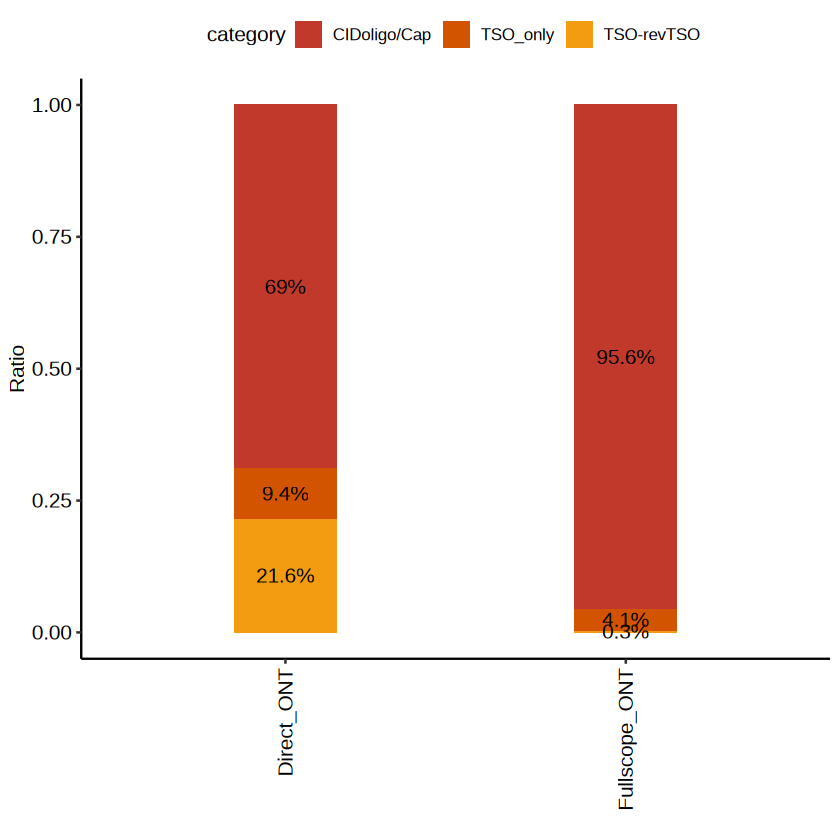

In [6]:
statdf$label  = paste0(as.character(round(statdf$proportion*100,1)),"%")
pstat = ggplot(statdf,aes(x = group,y = proportion,fill = category)) + 
    geom_bar(stat = "identity",width = 0.3) + 
    geom_text(aes(label = label),position = position_fill(0.5)) + 
    scale_fill_flatui() +
    theme_pubr() + theme(axis.text.x = element_text(angle = 90,hjust = 1,vjust = 0.5)) + xlab("") + ylab("Ratio")
pstat
ggexport(pstat,filename = "../../result/figure_revision/TSO_ratio_compare_25_12_16.pdf",width = 4,height = 5)